# **Project Supervised Learning**

---

## **Chatbot Spotify App Reviews**

### **Goal**

This project analyzes Spotify user reviews to predict customer sentiment using machine learning. The goal is to understand user satisfaction, provide insights for improving services, and allow interactive testing of predictions through a web interface using Streamlit.

### **Columns**

| Columns        | Descript                                                                                                      |
| ------------ | -------------------------------------------------------------------------------------------------------------- |
| `Time_submitted`     | At what time the review was submitted                                                                                 |
| `Review`        | Review text                                                             |
| `Rating`        | Given score (1-5)                                                                                       |
| `Total_thumbsup`    | How many people found the review helpful                                                              |
| `Reply`    | Review reply                                                                         |

---

### **1. Data Collection**

In [1]:
# 1. IMPORT & DOWNLOAD LIBRARIES AND PACKAGES

import pandas as pd
import numpy as np
import re
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import streamlit as st
from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('vader_lexicon')


# 2. LOAD DATASET

Reviews = pd.read_csv("reviews.csv")
Reviews = Reviews.rename(columns={col:col.strip() for col in Reviews.columns})  
print(f"Shape: {Reviews.shape}")
Reviews.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Shape: (61594, 5)


,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


### **2. Data Cleaning**

In [2]:
# 3. DATA CLEANING

Reviews['has_reply'] = Reviews['Reply'].notna().astype(int)
Reviews['Reply'] = Reviews['Reply'].fillna('')
print(Reviews.isnull().sum())

Time_submitted    0
Review            0
Rating            0
Total_thumbsup    0
Reply             0
has_reply         0
dtype: int64


In [3]:
Reviews['has_reply'].value_counts()

has_reply
0    61378
1      216
Name: count, dtype: int64

#### **Note:**

Reply column is intentionally not removed or filled, because doing so could change the meaning of the data. The NaN values in this column indicate that a review did not receive a reply.
To keep the original information while making the data easier to analyze, a new feature has_reply is added:

- 1 → the review has a reply

- 0 → the review has no reply

The has_reply feature helps support further analysis, such as understanding engagement patterns or brand response behavior. It also makes the data more suitable for machine learning models while still preserving important information about whether a review was responded to or not.

### **3. Exploratory Data Analysis**

In [4]:
Reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61594 entries, 0 to 61593
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Time_submitted  61594 non-null  object
 1   Review          61594 non-null  object
 2   Rating          61594 non-null  int64 
 3   Total_thumbsup  61594 non-null  int64 
 4   Reply           61594 non-null  object
 5   has_reply       61594 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 2.8+ MB


In [5]:
Reviews.describe()

,Rating,Total_thumbsup,has_reply
count,61594.000000,61594.000000,61594.000000
mean,3.155989,7.649381,0.003507
std,1.673285,89.323143,0.059115
min,1.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,3.000000,0.000000,0.000000
75%,5.000000,1.000000,0.000000
max,5.000000,8195.000000,1.000000


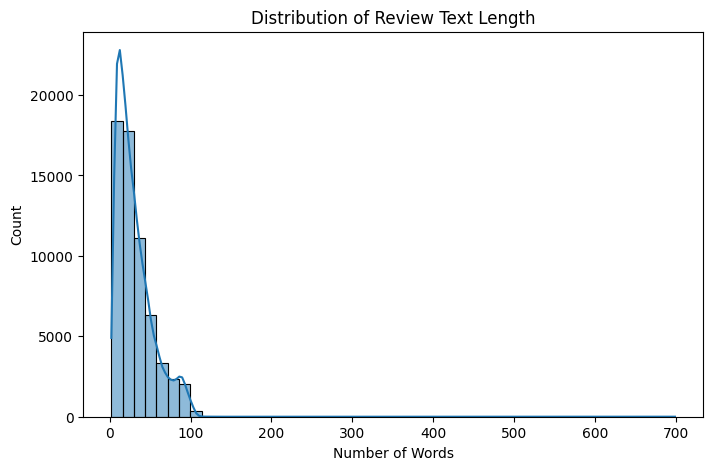

In [6]:
# 4. EXPLORATORY DATA ANALYSIS

# A. Text Length Distribution
Reviews["text_length"] = Reviews["Review"].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(8, 5))
sns.histplot(Reviews["text_length"], bins=50, kde=True)
plt.title("Distribution of Review Text Length")
plt.xlabel("Number of Words")
plt.ylabel("Count")
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_12332\1077066500.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Rating', data=Reviews, palette='Blues_r')


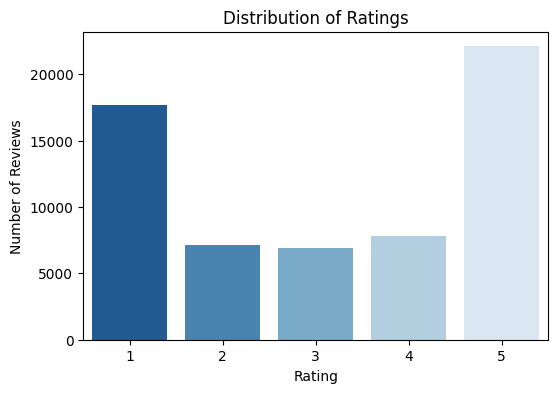

In [7]:
# B. Rating Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Rating', data=Reviews, palette='Blues_r')
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.show()

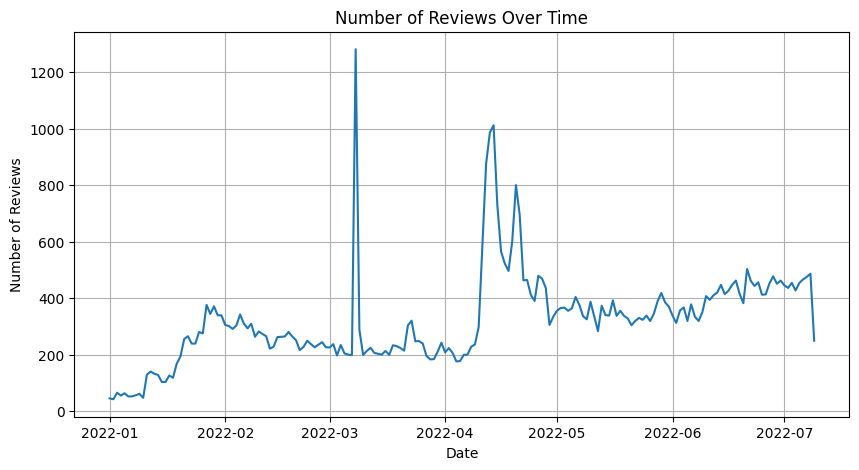

In [8]:
# C. Reviews Over Time
Reviews["Time_submitted"] = pd.to_datetime(Reviews["Time_submitted"], errors="coerce")  # Convert Time_submitted to datetime
review_per_day = Reviews.groupby(Reviews["Time_submitted"].dt.date).size()  # Group by date
plt.figure(figsize=(10, 5))
review_per_day.plot(kind="line")
plt.title("Number of Reviews Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Reviews")
plt.grid(True)
plt.show()

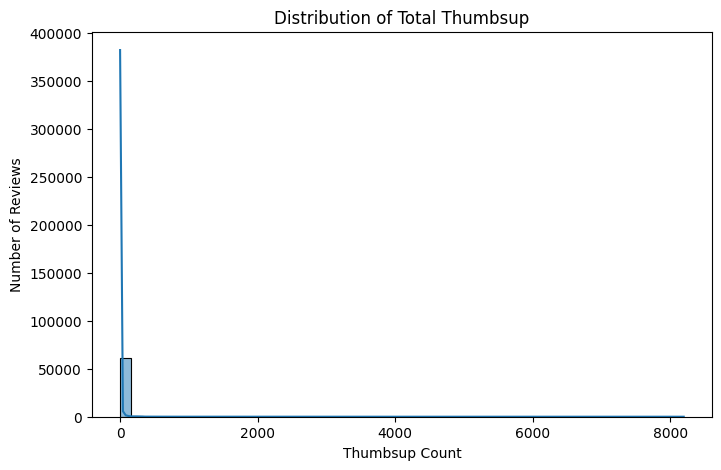

In [9]:
# D. Thumbsup Distribution
plt.figure(figsize=(8, 5))
sns.histplot(Reviews["Total_thumbsup"], bins=50, kde=True)
plt.title("Distribution of Total Thumbsup")
plt.xlabel("Thumbsup Count")
plt.ylabel("Number of Reviews")
plt.show()

#### **Note:**

The visualization indicates that the distribution of thumbsup counts is highly skewed, with most reviews receiving very few—often none—while only a small portion accumulate a large number of thumbsup.

- The majority of users read reviews without interacting, indicating low engagement.

- Reviews with high thumbsup counts are likely those that provide informative, representative, or attention-grabbing opinions.

- The extreme values (outliers) on the right side suggest the presence of reviews that became highly popular or “viral” among users.

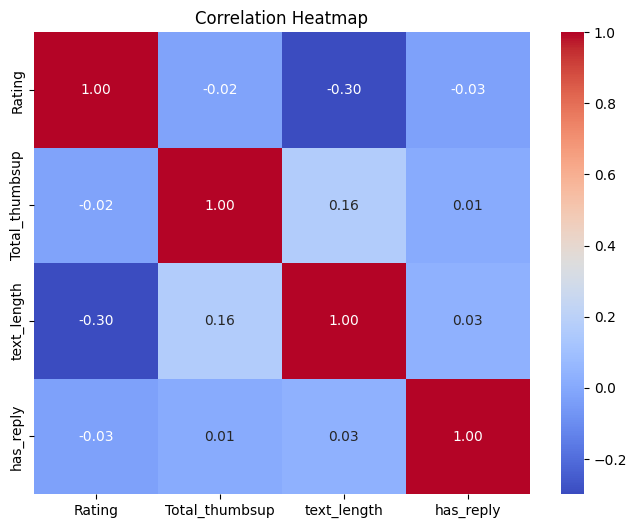

In [10]:
# E. Correlation Heatmap
numeric_cols = ["Rating", "Total_thumbsup", "text_length", "has_reply"]
corr = Reviews[numeric_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

### **4. Preprocessing Functions**

In [11]:
# 5. PREPROCESSING FUNCTIONS

stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(review): # review
    if pd.isna(review):
        return ""
    review = review.lower()
    review = re.sub(r'http\S+|www.\S+|@\w+|#|[^a-z\s]', ' ', review)
    tokens = nltk.word_tokenize(review)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop and len(token) > 1]
    return " ".join(tokens)

Reviews['clean_Reviews'] = Reviews['Review'].apply(clean_text)
Reviews[['Review','clean_Reviews']].head()

sia = SentimentIntensityAnalyzer()
Reviews["sentiment_score"] = Reviews["clean_Reviews"].apply(lambda x: sia.polarity_scores(x)["compound"])

# Converting scores into labels
def get_label(score):
    if score > 0.05:
        return "positive"
    elif score < -0.05:
        return "negative"
    else:
        return "neutral"
Reviews["sentiment"] = Reviews["sentiment_score"].apply(get_label)

### **5. Data Splitting**

In [12]:
X = Reviews["clean_Reviews"]
y = Reviews["sentiment"] 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

### **6. Build TF-IDF & Classifier Pipelines**

In [13]:
pipelines = {  
    'MultinomialNB': Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=20000)),
        ('clf', MultinomialNB())
    ]),
    
    'LogisticRegression': Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=20000)),
        ('clf', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    
    'RandomForest': Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=10000)),
        ('clf', RandomForestClassifier(n_estimators=200, random_state=42))
    ]),
    
    'LinearSVC': Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=20000)),
        ('clf', LinearSVC())
    ]),
    
    'KNN': Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=5000)),
        ('clf', KNeighborsClassifier(n_neighbors=5))
    ]),
    
    'DecisionTree': Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=10000)),
        ('clf', DecisionTreeClassifier(random_state=42))
    ])
}

### **7. Training & Evaluate Model**

Training MultinomialNB
MultinomialNB accuracy: 0.7746570338501502
              precision    recall  f1-score   support

    negative     0.6908    0.4420    0.5391      2552
     neutral     1.0000    0.0031    0.0061       982
    positive     0.7874    0.9575    0.8642      8785

    accuracy                         0.7747     12319
   macro avg     0.8261    0.4675    0.4698     12319
weighted avg     0.7843    0.7747    0.7284     12319



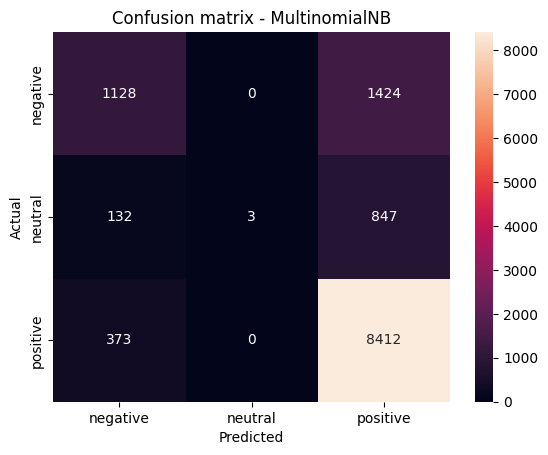

Training LogisticRegression
LogisticRegression accuracy: 0.8899261303677246
              precision    recall  f1-score   support

    negative     0.8459    0.7853    0.8145      2552
     neutral     0.8394    0.4206    0.5604       982
    positive     0.9036    0.9728    0.9369      8785

    accuracy                         0.8899     12319
   macro avg     0.8630    0.7262    0.7706     12319
weighted avg     0.8865    0.8899    0.8815     12319



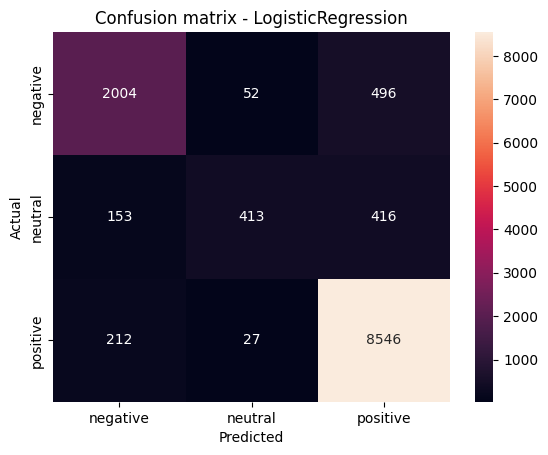

Training RandomForest
RandomForest accuracy: 0.8409773520577969
              precision    recall  f1-score   support

    negative     0.8481    0.5580    0.6731      2552
     neutral     0.7528    0.4094    0.5303       982
    positive     0.8444    0.9714    0.9035      8785

    accuracy                         0.8410     12319
   macro avg     0.8151    0.6463    0.7023     12319
weighted avg     0.8379    0.8410    0.8260     12319



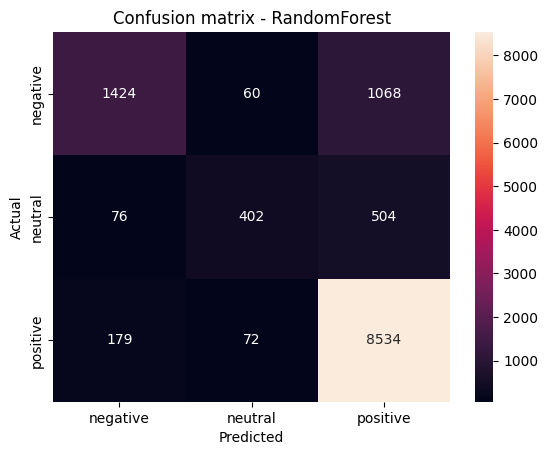

Training LinearSVC
LinearSVC accuracy: 0.8944719538923613
              precision    recall  f1-score   support

    negative     0.8145    0.8068    0.8106      2552
     neutral     0.7433    0.5367    0.6233       982
    positive     0.9285    0.9599    0.9440      8785

    accuracy                         0.8945     12319
   macro avg     0.8288    0.7678    0.7926     12319
weighted avg     0.8901    0.8945    0.8908     12319



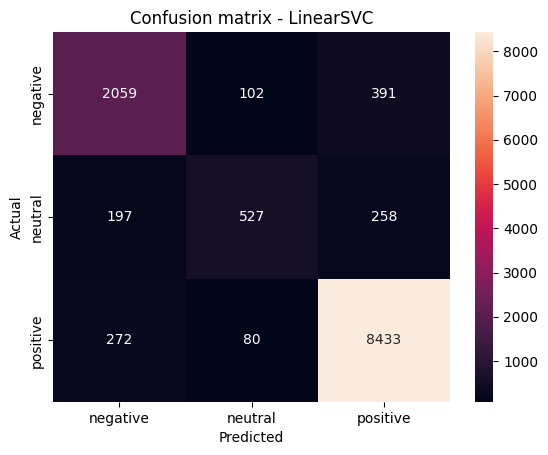

Training KNN
KNN accuracy: 0.2720188326974592
              precision    recall  f1-score   support

    negative     0.5178    0.0400    0.0742      2552
     neutral     0.0852    0.8126    0.1543       982
    positive     0.8884    0.2790    0.4246      8785

    accuracy                         0.2720     12319
   macro avg     0.4971    0.3772    0.2177     12319
weighted avg     0.7476    0.2720    0.3305     12319



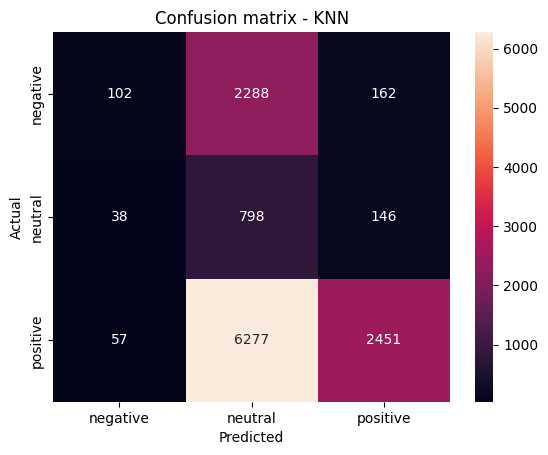

Training DecisionTree
DecisionTree accuracy: 0.8344021430310902
              precision    recall  f1-score   support

    negative     0.6640    0.6560    0.6600      2552
     neutral     0.7125    0.6965    0.7044       982
    positive     0.8962    0.9017    0.8989      8785

    accuracy                         0.8344     12319
   macro avg     0.7576    0.7514    0.7544     12319
weighted avg     0.8335    0.8344    0.8339     12319



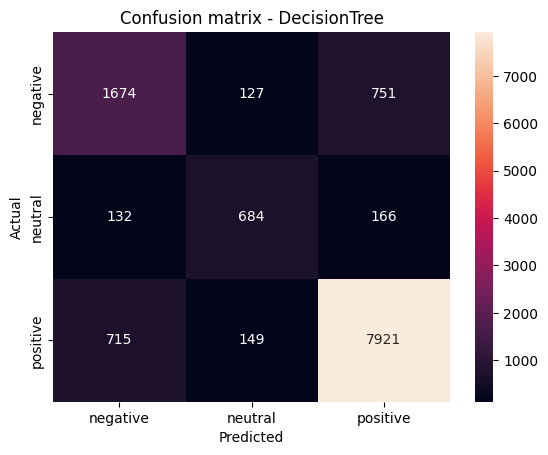

In [14]:
# 8. TRAIN & EVALUATE

results = {}
for name, pipe in pipelines.items():
    print("Training", name)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(name, "accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits=4))
    cm = confusion_matrix(y_test, y_pred, labels=['negative','neutral','positive'])
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=['negative','neutral','positive'], yticklabels=['negative','neutral','positive'])
    plt.title(f"Confusion matrix - {name}")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()
    results[name] = {'model': pipe, 'y_pred': y_pred}

#### **Evaluation Model Results**

| Model                  | Accuracy   | Precision (macro) | Recall (macro) | F1-score (macro) |
| ---------------------- | ---------- | ----------------- | -------------- | ---------------- |
| **MultinomialNB**      | 0.7746     | 0.8261            | 0.4675         | 0.4698           |
| **LogisticRegression** | 0.8899     | 0.8630            | 0.7262         | 0.7706       |
| **RandomForest**       | 0.8409     | 0.8151            | 0.6463         | 0.7023           |
| **LinearSVC**      | 0.8944     | 0.8288            | 0.7678         | 0.7926           |
| **KNN**       | 0.2720     | 0.4971            | 0.3772         | 0.2177           |
| **Desicion Tree**       | 0.8344     | 0.7576            | 0.7514         | 0.7544           |

#### **Note:**

The LinearSVC model achieved the best performance with the highest accuracy and F1-score, indicating strong and consistent predictions across all sentiment classes.

Models like KNN and Decision Tree performed poorly due to the high-dimensional and sparse nature of text features.

### **8. Save Model in Joblib**

In [15]:
# 9. SAVE BEST MODEL (joblib)

best = pipelines['LinearSVC']   
joblib.dump(best, "ReviewSentiment.joblib")
print("Saved model to ReviewSentiment.joblib")

Saved model to ReviewSentiment.joblib


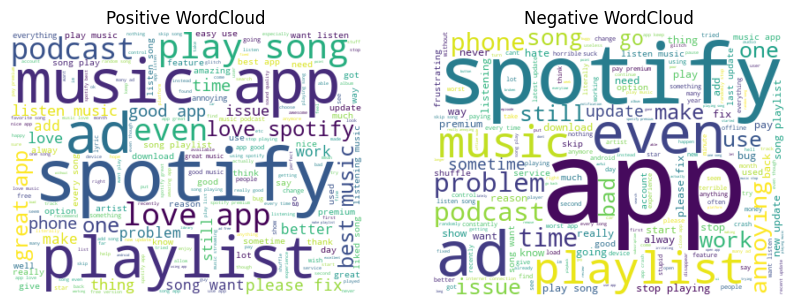

In [18]:
positive_reviews = Reviews[Reviews['sentiment'] == 'positive']['clean_Reviews']
negative_reviews = Reviews[Reviews['sentiment'] == 'negative']['clean_Reviews']

# Generate WordCloud
wc_positive = WordCloud(width=400, height=300, background_color='white').generate(" ".join(positive_reviews))
wc_negative = WordCloud(width=400, height=300, background_color='white').generate(" ".join(negative_reviews))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(wc_positive, interpolation='bilinear')
plt.title("Positive WordCloud")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(wc_negative, interpolation='bilinear')
plt.title("Negative WordCloud")
plt.axis('off')
plt.show()

In [ ]:
# Directly Attempting to Input a Review
while True:
    text = input("Input review (or type 'exit' to quit): ")
    if text.lower() == "exit":
        break
    pred = best.predict([text])[0]
    print("Sentiment Prediction:", pred)

---

## **Insight**

1. The majority of Spotify user reviews express positive sentiment, indicating a high level of user satisfaction with the service.

2. The LinearSVC model demonstrated the best performance with an accuracy of 89%, making it the most suitable choice for deployment.

3. The application of text preprocessing and TF-IDF significantly improved the model’s accuracy compared to a simpler baseline approach.

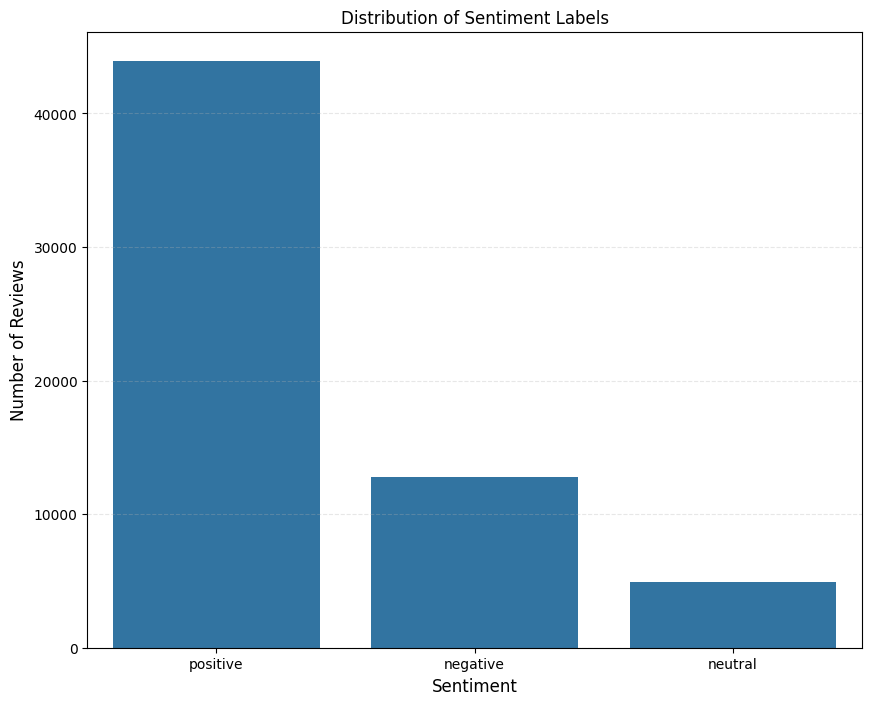

In [19]:
plt.figure(figsize=(10,8))
sns.countplot(x='sentiment', data=Reviews)
plt.title("Distribution of Sentiment Labels")
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()